# Training a neural network with McSnow accretion output

This script applies a DNN to the regression problem compare with Seifert and Beheng (2001)

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


### Load Tensorflow and other useful modules

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


### Load data from netcdf

In [2]:
import numpy as np
import xarray as xr

In [3]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="big_n5"
fname1=mdir+edir+'autocon_train_'+data+'.nc'
fname2=mdir+edir+'autocon_test_'+data+'.nc'
fname3=mdir+edir+'autocon_val_big_n2.nc'

ds1 = xr.open_dataset(fname1)
ds2 = xr.open_dataset(fname2)
ds2 = xr.open_dataset(fname3)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:     (i: 6, ii: 6, j: 7, jj: 7, k: 5, kk: 5, n: 5, nn: 5, nt: 4000)
Coordinates:
  * n           (n) int32 0 1 2 3 4
  * i           (i) int32 200 400 600 800 1000 2000
  * j           (j) int32 9 10 11 12 13 14 15
  * k           (k) int32 0 1 2 3 4
Dimensions without coordinates: ii, jj, kk, nn, nt
Data variables:
    time        (n, i, j, k, nt) float32 ...
    tau         (n, i, j, k, nt) float32 ...
    Lc          (n, i, j, k, nt) float32 ...
    Nc          (n, i, j, k, nt) float32 ...
    Zc          (n, i, j, k, nt) float32 ...
    Lr          (n, i, j, k, nt) float32 ...
    Nr          (n, i, j, k, nt) float32 ...
    Zr          (n, i, j, k, nt) float32 ...
    nu          (n, i, j, k, nt) float32 ...
    mue         (n, i, j, k, nt) float64 ...
    nue         (n, i, j, k, nt) float64 ...
    auto_num    (n, i, j, k, nt) float32 ...
    auto_mass   (n, i, j, k, nt) float32 ...
    accr_num    (n, i, j, k, nt) float32 ...
    accr_mass   (n

# Prepare data for training

In [4]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    tau  = xr.open_dataset(fname).tau.values
    acc  = xr.open_dataset(fname).accr_mass.values
    Lc   = xr.open_dataset(fname).Lc.values
    Lr   = xr.open_dataset(fname).Lr.values
    Nc   = xr.open_dataset(fname).Nc.values
    Nr   = xr.open_dataset(fname).Nr.values
    nu   = xr.open_dataset(fname).nu.values
    # transform everything except nu in log space
    L_min = 1e-15
    N_min = 1e-15
    tau_min  = 1e-15
    acc_min = 1e-15
    Xc = np.log(Lc/Nc, where=Nc>N_min)
    Xr = np.log(Lr/Nr, where=Nr>N_min)  # do Xr first!
    Nc = np.log(Nc, where=Nc>N_min)
    Lc = np.log(Lc, where=Lc>L_min)
    Nr = np.log(Nr, where=Nr>N_min)
    Lr = np.log(Lr, where=Lr>L_min)
    tau = np.log(tau, where=tau>tau_min, out=np.nan*tau)    
    acc = np.log(acc, where=acc>acc_min, out=np.nan*acc)
    # put everything in a pandas dataframe    
    dataset = pd.DataFrame(np.array( [ acc.ravel(), Lc.ravel(), Lr.ravel(), Xc.ravel(), Xr.ravel(), nu.ravel(), tau.ravel() ]))
    dataset = dataset.T
    dataset.columns = ['acc','Lc','Lr','Xc','Xr','nu','tau'] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [5]:
dataset_train = read_and_prepare_data(fname1)
dataset_test  = read_and_prepare_data(fname2)
dataset_val   = read_and_prepare_data(fname3)

/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/Volumes/MyBook/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

### Inspect the data

In [6]:
dataset_train.describe()

acc             Lc             Lr             Xc  \
count  390266.000000  390266.000000  390266.000000  390266.000000   
mean      -19.820944      -9.735505     -11.401494     -25.974607   
std         4.295667       2.381932       4.875874       0.650774   
min       -34.538765     -15.429439     -29.565296     -28.920919   
25%       -21.615437     -11.660074     -13.758996     -26.412858   
50%       -18.946712      -8.620265      -8.893823     -25.963396   
75%       -16.913187      -7.829179      -7.894393     -25.502439   
max       -11.982386      -6.215683      -6.216760     -24.881920   

                  Xr             nu            tau  
count  390266.000000  390266.000000  390266.000000  
mean      -17.312515       2.085209      -3.567672  
std         3.806687       1.390925       4.855076  
min       -22.069162       0.000000     -23.348867  
25%       -20.987723       1.000000      -5.892014  
50%       -18.102999       2.000000      -0.899198  
75%       -13.829069       3.000000      -0.021771  
max        -9.336143       4.000000      -0.001000

In [7]:
dataset_test.describe()

acc             Lc             Lr             Xc  \
count  228645.000000  228645.000000  228645.000000  228645.000000   
mean      -19.454084      -9.447169     -11.325500     -25.942194   
std         4.396365       2.328032       5.063498       0.589544   
min       -34.538635     -15.021038     -29.615793     -28.124483   
25%       -21.063938     -11.353958     -13.793944     -26.404255   
50%       -18.479082      -8.219941      -8.662282     -25.919214   
75%       -16.333021      -7.603813      -7.667846     -25.484699   
max       -12.561091      -6.503471      -6.504506     -24.882586   

                  Xr             nu            tau  
count  228645.000000  228645.000000  228645.000000  
mean      -17.338531       2.046043      -3.747119  
std         3.824919       1.107910       5.049244  
min       -22.068624       0.500000     -22.840141  
25%       -21.035391       1.500000      -6.196519  
50%       -18.180853       2.500000      -1.003565  
75%       -13.823285       3.500000      -0.023040  
max        -9.635016       3.500000      -0.001001

In [8]:
dataset_val.describe()

acc             Lc             Lr             Xc  \
count  155775.000000  155775.000000  155775.000000  155775.000000   
mean      -19.847206      -9.722435     -11.444781     -25.977428   
std         4.344949       2.375099       4.924421       0.649512   
min       -34.538105     -15.429268     -29.809435     -28.913774   
25%       -21.636795     -11.638552     -13.823686     -26.412060   
50%       -18.953108      -8.609550      -8.911941     -25.952501   
75%       -16.908571      -7.829194      -7.891315     -25.499071   
max       -11.999689      -6.215693      -6.216795     -24.883766   

                  Xr             nu            tau  
count  155775.000000  155775.000000  155775.000000  
mean      -17.339802       2.089045      -3.611192  
std         3.805493       1.392936       4.895990  
min       -22.068741       0.000000     -23.593521  
25%       -21.020947       1.000000      -5.969764  
50%       -18.145504       2.000000      -0.926062  
75%       -13.856678       3.000000      -0.022096  
max        -9.433998       4.000000      -0.001000

### Reduce the data

In [ ]:
def reduce_data(dataset):
    idx = dataset[ dataset['tau'] > np.log(0.99) ].index
    dataset.drop(idx,inplace=True)
    return dataset

In [ ]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)

In [ ]:
dataset_train.describe()

In [ ]:
dataset_test.describe()

In [ ]:
sns.pairplot(dataset_train[['acc','Lc','Lr','Xc','Xr','nu','tau']], diag_kind="kde")

## Separate in different dataset with selected sets of predictors

In [9]:
train_dataset0 = dataset_train.copy()
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()

test_dataset0 = dataset_test.copy()
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()

val_dataset0 = dataset_val.copy()
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()

In [10]:
train_dataset0 = train_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
train_dataset1 = train_dataset1.drop(['Xr','nu','tau'], axis=1)
train_dataset2 = train_dataset2.drop(['nu','tau'], axis=1)
train_dataset3 = train_dataset3.drop("tau", axis=1)
train_dataset4 = train_dataset4.drop(['Xc','Xr','nu'], axis=1)

In [11]:
test_dataset0 = test_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
test_dataset1 = test_dataset1.drop(['Xr','nu','tau'], axis=1)
test_dataset2 = test_dataset2.drop(['nu','tau'], axis=1)
test_dataset3 = test_dataset3.drop('tau', axis=1)
test_dataset4 = test_dataset4.drop(['Xc','Xr','nu'], axis=1)

In [12]:
val_dataset0 = val_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
val_dataset1 = val_dataset1.drop(['Xr','nu','tau'], axis=1)
val_dataset2 = val_dataset2.drop(['nu','tau'], axis=1)
val_dataset3 = val_dataset3.drop('tau', axis=1)
val_dataset4 = val_dataset4.drop(['Xc','Xr','nu'], axis=1)

In [13]:
train_stats0 = train_dataset0.describe()
train_stats0.pop("acc")
train_stats0 = train_stats0.transpose()
train_stats0

count       mean       std        min        25%       50%       75%  \
Lc  390266.0  -9.735505  2.381932 -15.429439 -11.660074 -8.620265 -7.829179   
Lr  390266.0 -11.401494  4.875874 -29.565296 -13.758996 -8.893823 -7.894393   

         max  
Lc -6.215683  
Lr -6.216760

In [14]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("acc")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%        75%  \
Lc  390266.0  -9.735505  2.381932 -15.429439 -11.660074  -8.620265  -7.829179   
Lr  390266.0 -11.401494  4.875874 -29.565296 -13.758996  -8.893823  -7.894393   
Xc  390266.0 -25.974607  0.650774 -28.920919 -26.412858 -25.963396 -25.502439   

          max  
Lc  -6.215683  
Lr  -6.216760  
Xc -24.881920

In [15]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("acc")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std        min        25%        50%        75%  \
Lc  390266.0  -9.735505  2.381932 -15.429439 -11.660074  -8.620265  -7.829179   
Lr  390266.0 -11.401494  4.875874 -29.565296 -13.758996  -8.893823  -7.894393   
Xc  390266.0 -25.974607  0.650774 -28.920919 -26.412858 -25.963396 -25.502439   
Xr  390266.0 -17.312515  3.806687 -22.069162 -20.987723 -18.102999 -13.829069   

          max  
Lc  -6.215683  
Lr  -6.216760  
Xc -24.881920  
Xr  -9.336143

In [16]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("acc")
train_stats3 = train_stats3.transpose()
train_stats3

count       mean       std        min        25%        50%        75%  \
Lc  390266.0  -9.735505  2.381932 -15.429439 -11.660074  -8.620265  -7.829179   
Lr  390266.0 -11.401494  4.875874 -29.565296 -13.758996  -8.893823  -7.894393   
Xc  390266.0 -25.974607  0.650774 -28.920919 -26.412858 -25.963396 -25.502439   
Xr  390266.0 -17.312515  3.806687 -22.069162 -20.987723 -18.102999 -13.829069   
nu  390266.0   2.085209  1.390925   0.000000   1.000000   2.000000   3.000000   

          max  
Lc  -6.215683  
Lr  -6.216760  
Xc -24.881920  
Xr  -9.336143  
nu   4.000000

In [17]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("acc")
train_stats4 = train_stats4.transpose()
train_stats4

count       mean       std        min        25%       50%       75%  \
Lc   390266.0  -9.735505  2.381932 -15.429439 -11.660074 -8.620265 -7.829179   
Lr   390266.0 -11.401494  4.875874 -29.565296 -13.758996 -8.893823 -7.894393   
tau  390266.0  -3.567672  4.855076 -23.348867  -5.892014 -0.899198 -0.021771   

          max  
Lc  -6.215683  
Lr  -6.216760  
tau -0.001000

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [18]:
train_labels0 = train_dataset0.pop('acc')
train_labels1 = train_dataset1.pop('acc')
train_labels2 = train_dataset2.pop('acc')
train_labels3 = train_dataset3.pop('acc')
train_labels4 = train_dataset4.pop('acc')

test_labels0  = test_dataset0.pop('acc')
test_labels1  = test_dataset1.pop('acc')
test_labels2  = test_dataset2.pop('acc')
test_labels3  = test_dataset3.pop('acc')
test_labels4  = test_dataset4.pop('acc')

In [19]:
val_labels0  = val_dataset0.pop('acc')
val_labels1  = val_dataset1.pop('acc')
val_labels2  = val_dataset2.pop('acc')
val_labels3  = val_dataset3.pop('acc')
val_labels4  = val_dataset4.pop('acc')

### Normalize the data

In [20]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data0 = norm(train_dataset0,train_stats0)
normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)

normed_test_data0 = norm(test_dataset0,train_stats0)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)

In [33]:
normed_val_data0 = norm(val_dataset0,train_stats0)
normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)

In [21]:
normed_train_stats0 = normed_train_data0.describe()
normed_train_stats0 = normed_train_stats0.transpose()
normed_train_stats0

count      mean       std       min       25%       50%       75%  \
Lc  390266.0  0.000707  0.999894 -2.390469 -0.807987  0.468208  0.800328   
Lr  390266.0 -0.000586  0.999929 -3.725241 -0.483503  0.514302  0.719276   

         max  
Lc  1.477717  
Lr  1.063345

In [22]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count      mean       std       min       25%       50%       75%  \
Lc  390266.0  0.000707  0.999894 -2.390469 -0.807987  0.468208  0.800328   
Lr  390266.0 -0.000586  0.999929 -3.725241 -0.483503  0.514302  0.719276   
Xc  390266.0 -0.006275  0.999997 -4.527393 -0.673430  0.017228  0.725548   

         max  
Lc  1.477717  
Lr  1.063345  
Xc  1.679057

In [23]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count      mean       std       min       25%       50%       75%  \
Lc  390266.0  0.000707  0.999894 -2.390469 -0.807987  0.468208  0.800328   
Lr  390266.0 -0.000586  0.999929 -3.725241 -0.483503  0.514302  0.719276   
Xc  390266.0 -0.006275  0.999997 -4.527393 -0.673430  0.017228  0.725548   
Xr  390266.0  0.000422  1.000035 -1.249550 -0.965461 -0.207657  0.915086   

         max  
Lc  1.477717  
Lr  1.063345  
Xc  1.679057  
Xr  2.095358

In [24]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean       std       min       25%       50%       75%  \
Lc  390266.0  7.072454e-04  0.999894 -2.390469 -0.807987  0.468208  0.800328   
Lr  390266.0 -5.862124e-04  0.999929 -3.725241 -0.483503  0.514302  0.719276   
Xc  390266.0 -6.275222e-03  0.999997 -4.527393 -0.673430  0.017228  0.725548   
Xr  390266.0  4.217306e-04  1.000035 -1.249550 -0.965461 -0.207657  0.915086   
nu  390266.0 -7.501326e-08  0.999788 -1.499153 -0.780207 -0.061260  0.657686   

         max  
Lc  1.477717  
Lr  1.063345  
Xc  1.679057  
Xr  2.095358  
nu  1.376632

In [25]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count      mean       std       min       25%       50%       75%  \
Lc   390266.0  0.000707  0.999894 -2.390469 -0.807987  0.468208  0.800328   
Lr   390266.0 -0.000586  0.999929 -3.725241 -0.483503  0.514302  0.719276   
tau  390266.0 -0.000334  1.000290 -4.074333 -0.478745  0.549625  0.730349   

          max  
Lc   1.477717  
Lr   1.063345  
tau  0.734627

# The model

## Build the model

In [26]:

def build_model_tanh(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='tanh'),
    layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='tanh', input_shape=[ncol]),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(16, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, input_shape=[ncol]),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(16, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,learn):
  model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=[ncol]),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(16, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,activation,learning_rate):
    if activation == "tanh":
        model = build_model_tanh(ncol,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [27]:

#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
activ = "ReLU"

model = build_model(2,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [29]:
example_batch  = normed_train_data0[:10]
example_result = model.predict(example_batch)
example_result

array([[0.4961892 ],
       [0.492846  ],
       [0.4913283 ],
       [0.478897  ],
       [0.469681  ],
       [0.4465112 ],
       [0.44297436],
       [0.44228405],
       [0.44024548],
       [0.43945554]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [30]:
# maximum number, but we use early stopping
EPOCHS = 100

# learning rate
learn = 1e-3        # original value is 1e-3, but smaller might be better?

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# for collecting the histories
histories = {}

In [34]:
model0 = build_model(len(normed_train_data0.keys()),activ,learn)

early_history0 = model0.fit(normed_train_data0, train_labels0, 
                    epochs=EPOCHS, validation_data=[normed_val_data0,val_labels0], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2.9968,  mae:0.4768,  mse:2.9968,  val_loss:0.1466,  val_mae:0.2485,  val_mse:0.1466,  
...........................

Text(0, 0.5, 'MAE')

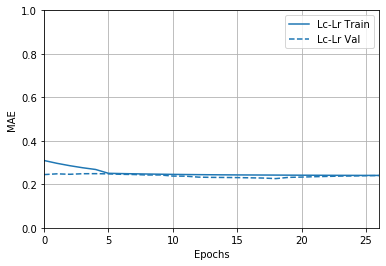

In [35]:
histories['Lc-Lr'] = early_history0

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [36]:
model1 = build_model(len(normed_train_data1.keys()),activ,learn)

early_history1 = model1.fit(normed_train_data1, train_labels1, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,val_labels1], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.7812,  mae:0.5632,  mse:4.7812,  val_loss:0.1124,  val_mae:0.1762,  val_mse:0.1124,  
...........................

Text(0, 0.5, 'MAE')

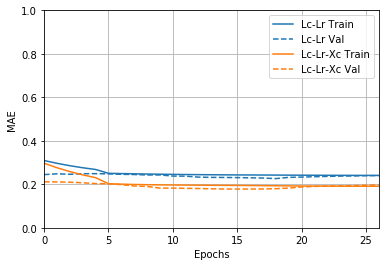

In [37]:
histories['Lc-Lr-Xc'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [38]:
model2 = build_model(len(normed_train_data2.keys()),activ,learn)

early_history2 = model2.fit(normed_train_data2, train_labels2, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,val_labels2], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2.5529,  mae:0.4255,  mse:2.5529,  val_loss:0.1103,  val_mae:0.1526,  val_mse:0.1103,  
.................................

Text(0, 0.5, 'MAE')

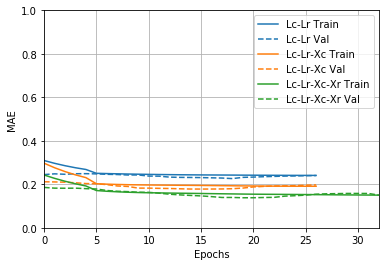

In [39]:
histories['Lc-Lr-Xc-Xr'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 1])
plt.ylabel('MAE')

In [40]:
model3 = build_model(len(normed_train_data3.keys()),activ,learn)

early_history3 = model3.fit(normed_train_data3, train_labels3, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,val_labels3], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:4.2112,  mae:0.5090,  mse:4.2112,  val_loss:0.1262,  val_mae:0.2158,  val_mse:0.1262,  
..............................................................................

Text(0, 0.5, 'MAE')

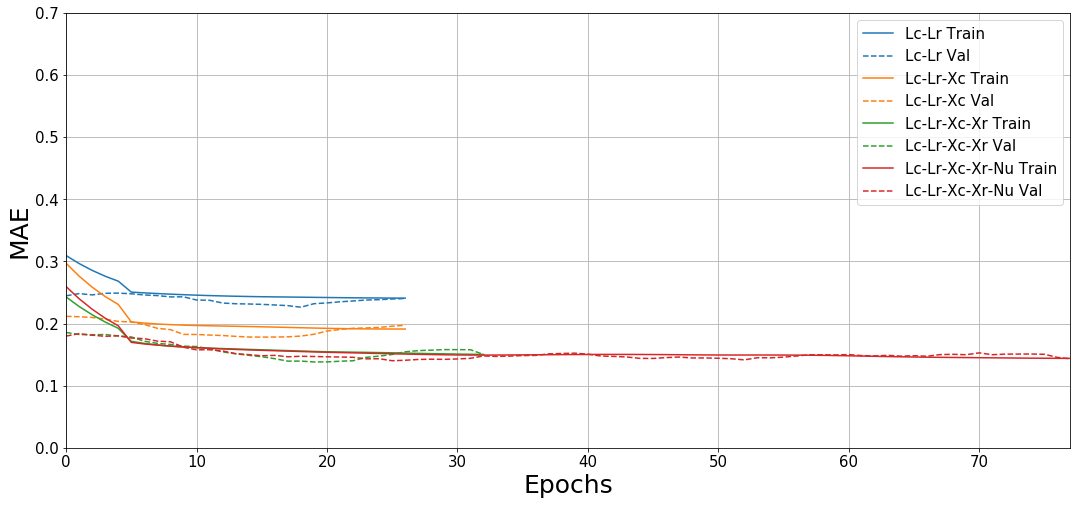

In [85]:
histories['Lc-Lr-Xc-Xr-nu'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0, 0.7])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

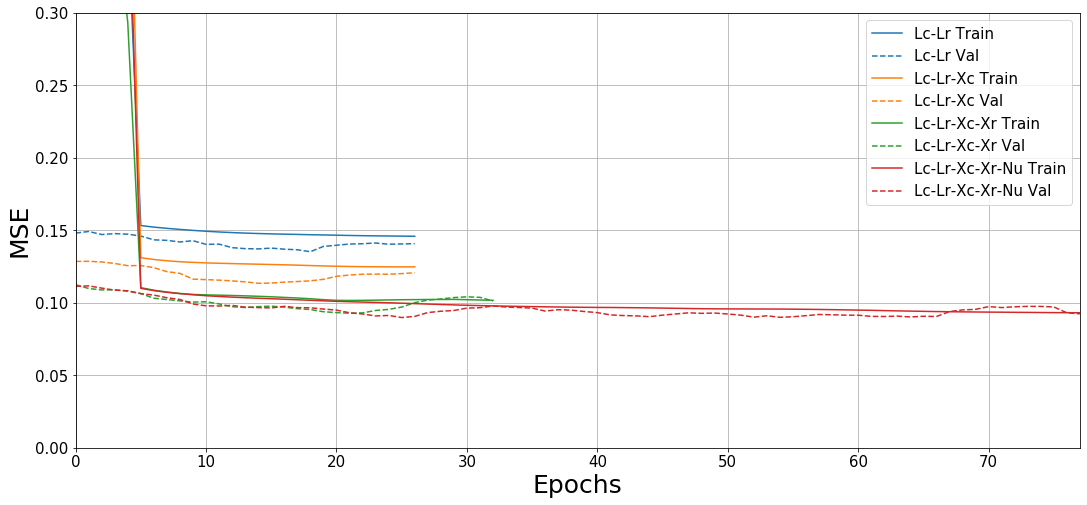

In [84]:
plotter.plot(histories, metric = "mse")
plt.ylim([0, 0.3])
plt.ylabel('MSE')

In [43]:
loss0, mae0, mse0 = model0.evaluate(normed_test_data0, test_labels0, verbose=2)

print("Testing set for model 0, Mean Abs Error: {:10.5f}".format(mae0))

228645/228645 - 5s - loss: 0.1157 - mae: 0.2214 - mse: 0.1157
Testing set for model 0, Mean Abs Error:    0.22136


In [44]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, test_labels1, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

228645/228645 - 5s - loss: 0.0952 - mae: 0.1704 - mse: 0.0952
Testing set for model 1, Mean Abs Error:    0.17035


In [45]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, test_labels2, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:10.5f}".format(mae2))

228645/228645 - 5s - loss: 0.0729 - mae: 0.1253 - mse: 0.0729
Testing set for model 2, Mean Abs Error:    0.12529


In [46]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, test_labels3, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:10.5f}".format(mae3))

228645/228645 - 5s - loss: 0.0770 - mae: 0.1289 - mse: 0.0770
Testing set for model 3, Mean Abs Error:    0.12891


# Make predictions

Finally, predict the fall velocity values using data in the testing set:

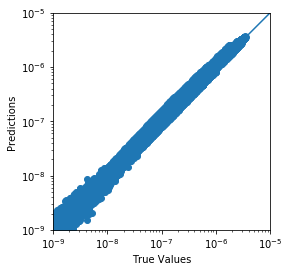

In [47]:
test_acc0 = np.exp(test_labels0)
test_acc1 = np.exp(test_labels1)
test_acc2 = np.exp(test_labels2)
test_acc3 = np.exp(test_labels3)
test_acc4 = np.exp(test_labels4)

test_predict0 = np.exp(model0.predict(normed_test_data0).flatten())
test_predict1 = np.exp(model1.predict(normed_test_data1).flatten())
test_predict2 = np.exp(model2.predict(normed_test_data2).flatten())

amin, amax = 1e-9, 1e-5

a = plt.axes(aspect='equal')
plt.scatter(test_acc2, test_predict2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

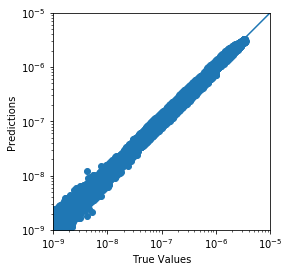

In [48]:
test_predict3 = np.exp(model3.predict(normed_test_data3).flatten())

a = plt.axes(aspect='equal')
plt.scatter(test_acc3, test_predict3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Compare with SB2001 and KK2000

In [49]:
test_dataset4.describe()

Lc             Lr            tau
count  228645.000000  228645.000000  228645.000000
mean       -9.447169     -11.325500      -3.747119
std         2.328032       5.063498       5.049244
min       -15.021038     -29.615793     -22.840141
25%       -11.353958     -13.793944      -6.196519
50%        -8.219941      -8.662282      -1.003565
75%        -7.603813      -7.667846      -0.023040
max        -6.503471      -6.504506      -0.001001

In [50]:
qc  = np.exp(np.array(test_dataset4.Lc))
qr  = np.exp(np.array(test_dataset4.Lr))

tau2 = qr/(qc+qr)

## SB2001 autoconversion rate, original and re-trained on current data

In [51]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

phi = (tau2 / (tau2 + 5e-4))**4

accSB = kcr * qc * qr * phi


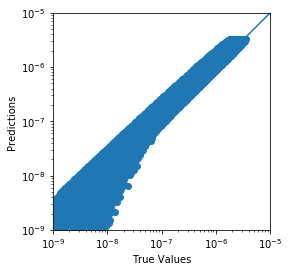

In [52]:
test_predict_sb = accSB

a = plt.axes(aspect='equal')
plt.scatter(test_acc4, test_predict_sb)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Power law regression 

from notebook 'McSnow_autocon_powerlaws'

In [53]:
fac = 6.0
a = 1.1
b = 1.0
c = 0.1


# AU = fac * Lc**a * Nc**b * nu**c
accPwr = fac * np.power(qc,a) * np.power(qr,b) #* np.power(nu+1,c)  

In [54]:
np.mean(accPwr)

6.291674e-08

## KK2000 accretion

In [55]:

accKK = 67. * np.power(qc*qr,1.15) 

In [56]:
np.mean(accKK)

1.4364576e-07

## Final statistics 

In [57]:
acc0 = test_predict0
acc1 = test_predict1
acc2 = test_predict2
acc3 = test_predict3

accTruth = test_acc4

In [58]:
np.max(accTruth)

3.5058014873357024e-06

In [59]:
def mean_abs_error(au, auTrue):  
    return np.mean(np.abs(au - auTrue))

def mean_sqr_error(au, auTrue):    
    return np.sqrt(np.mean((au - auTrue)**2))                   

In [60]:
mae0 = mean_abs_error(acc0,test_acc0)
mae1 = mean_abs_error(acc1,test_acc1)
mae2 = mean_abs_error(acc2,test_acc2)
mae3 = mean_abs_error(acc3,test_acc3)
maeSB = mean_abs_error(accSB,accTruth)
maeKK  = mean_abs_error(accKK,accTruth)
maePwr = mean_abs_error(accPwr,accTruth)

mse0 = mean_sqr_error(acc0,test_acc0)
mse1 = mean_sqr_error(acc1,test_acc1)
mse2 = mean_sqr_error(acc2,test_acc2)
mse3 = mean_sqr_error(acc3,test_acc3)
mseSB = mean_sqr_error(accSB,accTruth)
#mseSB2 = mean_sqr_error(accSB2,accTruth)
mseKK  = mean_sqr_error(accKK,accTruth)
msePwr = mean_sqr_error(accPwr,accTruth)

mae = [ mae0, mae1, mae2, mae3, maeSB, maeKK ] #, maeSB2, maeKK, maePwr ]
mse = [ mse0, mse1, mse2, mse3, mseSB, mseKK ] #, mseSB2, mseKK, msePwr ]

In [61]:
mae

[1.5757553484263553e-08,
 6.350070691496512e-09,
 5.507565958851046e-09,
 6.099040827933777e-09,
 2.214413186152342e-08,
 3.3850309222316355e-08]

In [62]:
labels = list(histories.keys())
labels.append('SB2001')
labels.append('KK2000')
labels

['Lc-Lr', 'Lc-Lr-Xc', 'Lc-Lr-Xc-Xr', 'Lc-Lr-Xc-Xr-nu', 'SB2001', 'KK2000']

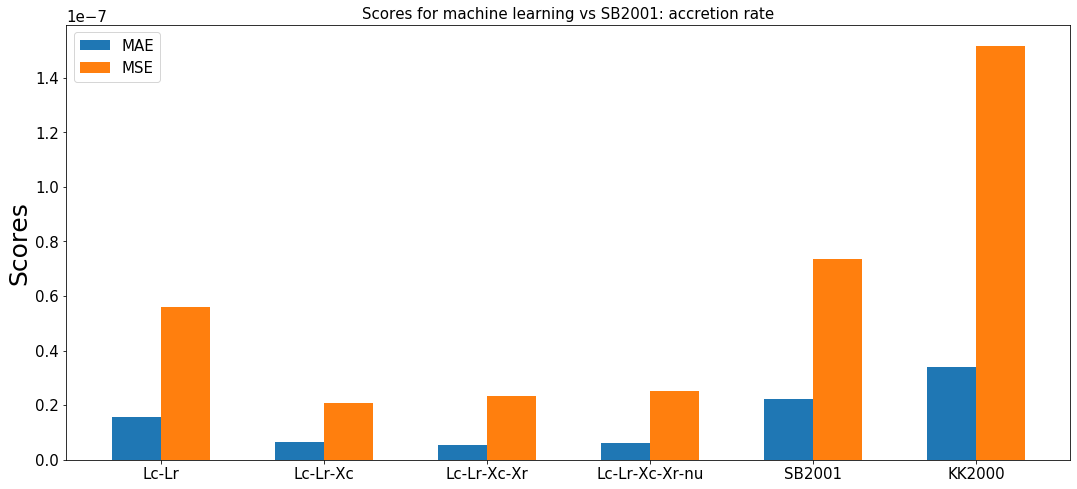

In [63]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size
#labels = [ 'Lc-Lr', 'Lc-Lr-Nc', 'Lc-Lr-Nr', 'Lc-Lr-Nc-Nr', 'Lc-Lr-Nc-Nr-nu', 'SB2001' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label='MAE')
rects2 = ax.bar(x + width/2, mse, width, label='MSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for machine learning vs SB2001: accretion rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#fig.tight_layout()

plt.show()



In [64]:
fig.savefig("accretion_barplot_v7_"+activ+"_"+data+"_eps15.png", bbox_inches='tight', dpi=600)

# Save models and normalization

In [65]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model_v7

model0.save('saved_model_v7/accretion_v7_LcLr_'+activ+'_16x16x16_'+data) 
model1.save('saved_model_v7/accretion_v7_LcLrXc_'+activ+'_16x16x16_'+data) 
model2.save('saved_model_v7/accretion_v7_LcLrXcXr_'+activ+'_16x16x16_'+data) 
model3.save('saved_model_v7/accretion_v7_LcLrXcXrNu_'+activ+'_16x16x16_'+data) 

# save train_stats for normalization of input data in Pandas pickle format
train_stats0.to_pickle('saved_model_v7/accretion_v7_LcLr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats1.to_pickle('saved_model_v7/accretion_v7_LcLrXc_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats2.to_pickle('saved_model_v7/accretion_v7_LcLrXcXr_'+activ+'_16x16x16_'+data+'_norm.pickle')
train_stats3.to_pickle('saved_model_v7/accretion_v7_LcLrXcXrNu_'+activ+'_16x16x16_'+data+'_norm.pickle')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_v7/accretion_v7_LcLr_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/accretion_v7_LcLrXc_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/accretion_v7_LcLrXcXr_ReLU_16x16x16_big_n5/assets
INFO:tensorflow:Assets written to: saved_model_v7/accretion_v7_LcLrXcXrNu_ReLU_16x16x16_big_n5/assets


# Model on gridded data to visualize dependencies

In [66]:

qc1d = np.linspace(0.1,1.0,10) * 1e-3
qr1d = np.linspace(0.1,1.0,11)
nu1d = np.linspace(0,3,6)
rc1d = np.linspace(11,15,9) * 1e-6
rr1d = np.linspace(0.05,2,12) * 1e-3

qc3d, qr3d, rc3d, rr3d, nu3d = np.meshgrid(qc1d, qr1d, rc1d, rr1d, nu1d)

xc3d = 4./3. * 3.14 * 1e3 * rc3d**3
nc3d = qc3d/xc3d
xr3d = 4./3. * 3.14 * 1e3 * rr3d**3
nr3d = qr3d/xr3d

In [67]:
nr3d.shape

(11, 10, 9, 12, 6)

In [68]:
nc3d.shape

(11, 10, 9, 12, 6)

In [69]:
gdata = pd.DataFrame(np.array( [ np.log(qc3d.ravel()), np.log(qr3d.ravel()), np.log(xc3d.ravel()), np.log(xr3d.ravel()), nu3d.ravel() ]))
gdata = gdata.T
gdata.columns = [ 'Lc','Lr','Xc','Xr','nu' ] 

In [70]:
gdata.describe()

Lc            Lr            Xc            Xr            nu
count  71280.000000  71280.000000  71280.000000  71280.000000  71280.000000
mean      -7.699899     -0.787151    -25.426947    -13.315308      1.500000
std        0.695412      0.684916      0.299968      3.064076      1.024702
min       -9.210340     -2.302585    -25.913186    -21.370803      0.000000
25%       -8.111728     -1.272966    -25.652152    -14.280943      0.600000
50%       -7.509742     -0.597837    -25.412023    -12.320787      1.500000
75%       -7.130899     -0.198451    -25.189700    -11.146037      2.400000
max       -6.907755      0.000000    -24.982721    -10.304164      3.000000

In [71]:
gdata0 = gdata.copy()
gdata2 = gdata.copy()
gdata3 = gdata.copy()

In [72]:
gdata0 = gdata.drop(['Xc','Xr','nu'], axis=1)
gdata2 = gdata.drop(['nu'], axis=1)
#gdata3 = gdata.drop(['tau'], axis=1)


#train_dataset0 = train_dataset0.drop(['Xc','Xr','nu','tau'], axis=1)
#train_dataset1 = train_dataset1.drop(['Xr','nu','tau'], axis=1)
#train_dataset2 = train_dataset2.drop(['nu','tau'], axis=1)
#train_dataset3 = train_dataset3.drop("tau", axis=1)
#train_dataset4 = train_dataset4.drop(['Xc','Xr','nu'], axis=1))

In [73]:
gdata3.head()

Lc        Lr         Xc         Xr   nu
0 -9.21034 -2.302585 -25.913186 -21.370803  0.0
1 -9.21034 -2.302585 -25.913186 -21.370803  0.6
2 -9.21034 -2.302585 -25.913186 -21.370803  1.2
3 -9.21034 -2.302585 -25.913186 -21.370803  1.8
4 -9.21034 -2.302585 -25.913186 -21.370803  2.4

In [74]:
gdata3_stats = gdata3.describe()
gdata3_stats.transpose()

count       mean       std        min        25%        50%        75%  \
Lc  71280.0  -7.699899  0.695412  -9.210340  -8.111728  -7.509742  -7.130899   
Lr  71280.0  -0.787151  0.684916  -2.302585  -1.272966  -0.597837  -0.198451   
Xc  71280.0 -25.426947  0.299968 -25.913186 -25.652152 -25.412023 -25.189700   
Xr  71280.0 -13.315308  3.064076 -21.370803 -14.280943 -12.320787 -11.146037   
nu  71280.0   1.500000  1.024702   0.000000   0.600000   1.500000   2.400000   

          max  
Lc  -6.907755  
Lr   0.000000  
Xc -24.982721  
Xr -10.304164  
nu   3.000000

In [75]:
normed_gdata0 = norm(gdata0,train_stats0)
normed_gdata2 = norm(gdata2,train_stats2)
normed_gdata3 = norm(gdata3,train_stats3)

normed_gdata3_stats = normed_gdata3.describe()
normed_gdata3_stats.transpose()

count      mean       std       min       25%       50%       75%  \
Lc  71280.0  0.854603  0.291953  0.220479  0.681706  0.934436  1.093485   
Lr  71280.0  2.176911  0.140470  1.866108  2.077275  2.215738  2.297648   
Xc  71280.0  0.841551  0.460940  0.094383  0.495496  0.864484  1.206114   
Xr  71280.0  1.050049  0.804919 -1.066094  0.796381  1.311305  1.619907   
nu  71280.0 -0.420733  0.736706 -1.499153 -1.067785 -0.420733  0.226318   

         max  
Lc  1.187167  
Lr  2.338349  
Xc  1.524163  
Xr  1.841063  
nu  0.657686

In [76]:
acc0 = model0.predict(normed_gdata0).flatten()
acc2 = model2.predict(normed_gdata2).flatten()
acc3 = model3.predict(normed_gdata3).flatten()

In [77]:
acc3d_model0 = np.exp(np.reshape(acc0,qc3d.shape))
acc3d_model2 = np.exp(np.reshape(acc2,qc3d.shape))
acc3d_model3 = np.exp(np.reshape(acc3,qc3d.shape))

In [78]:
qc3d.shape

(11, 10, 9, 12, 6)

In [79]:
kcr = 5.78      # Long kernel in m3 kg-1 s-1 

tau = qr3d/(qc3d+qr3d)
phi = (tau / (tau + 5e-4))**4

accSB = kcr * qc3d * qr3d * phi

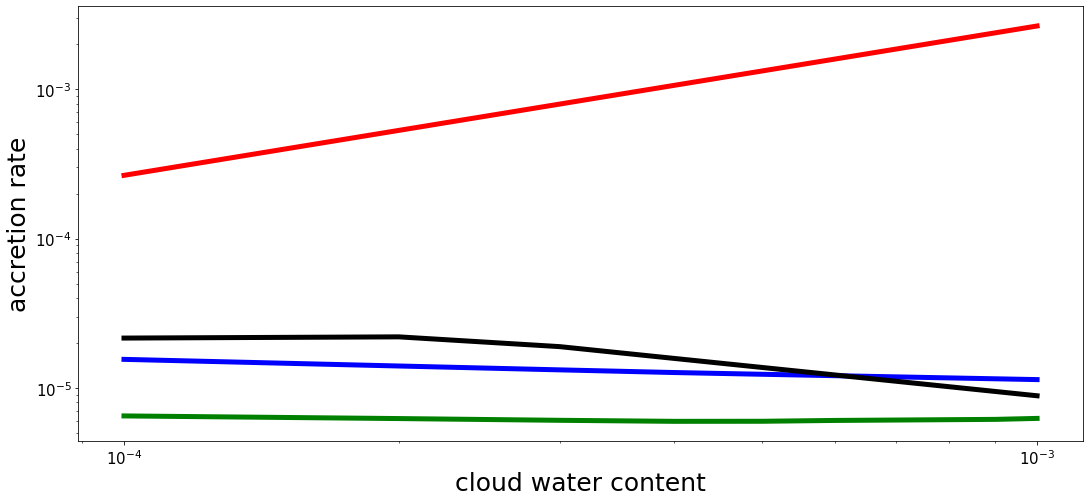

In [80]:
iqc = 5
iqr = 4
irc = 4
irr = 3
inu = 1

plt.plot(qc3d[iqr,:,irc,irr,inu], acc3d_model0[iqr,:,irc,irr,inu], 'g-', linewidth=5)
plt.plot(qc3d[iqr,:,irc,irr,inu], acc3d_model2[iqr,:,irc,irr,inu], 'b-', linewidth=5)
plt.plot(qc3d[iqr,:,irc,irr,inu], acc3d_model3[iqr,:,irc,irr,inu], 'k-', linewidth=5)
plt.plot(qc3d[iqr,:,irc,irr,inu], accSB[iqr,:,irc,irr,inu], 'r-', linewidth=5)

plt.xlabel('cloud water content')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

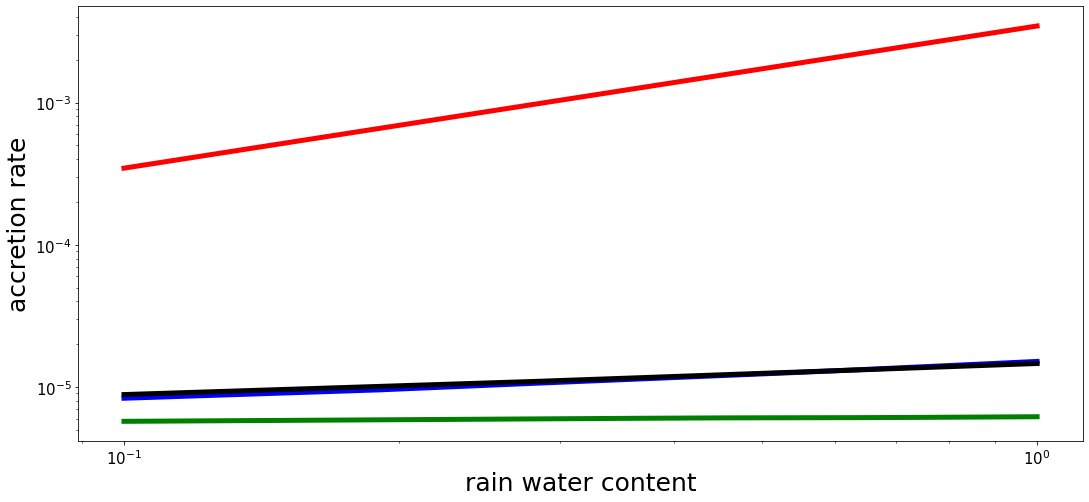

In [81]:
plt.plot(qr3d[:,iqc,irc,irr,inu], acc3d_model0[:,iqc,irc,irr,inu], 'g-', linewidth=5)
plt.plot(qr3d[:,iqc,irc,irr,inu], acc3d_model2[:,iqc,irc,irr,inu], 'b-', linewidth=5)
plt.plot(qr3d[:,iqc,irc,irr,inu], acc3d_model3[:,iqc,irc,irr,inu], 'k-', linewidth=5)
plt.plot(qr3d[:,iqc,irc,irr,inu], accSB[:,iqc,irc,irr,inu], 'r-', linewidth=5)

plt.xlabel('rain water content')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

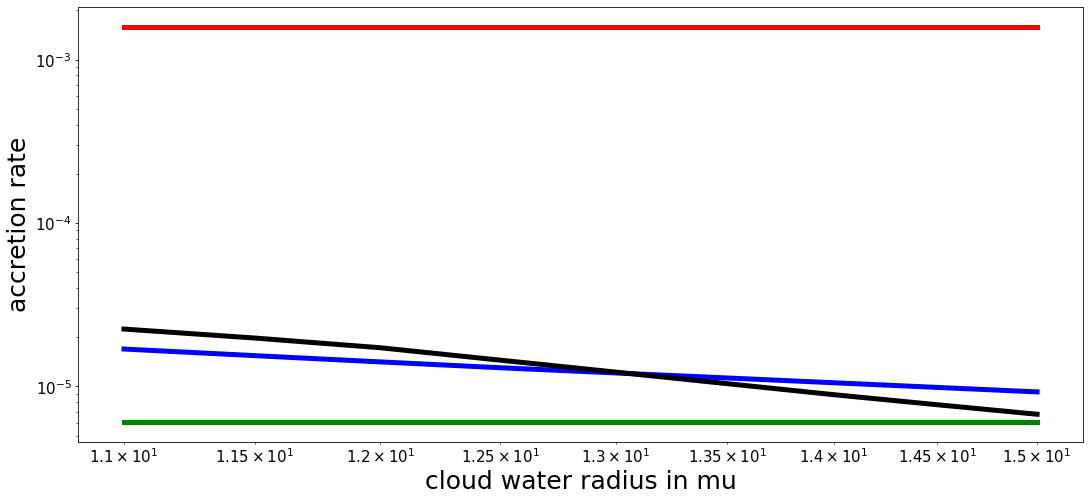

In [82]:

plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, acc3d_model0[iqr,iqc,:,irr,inu], 'g-', linewidth=5)
plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, acc3d_model2[iqr,iqc,:,irr,inu], 'b-', linewidth=5)
plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, acc3d_model3[iqr,iqc,:,irr,inu], 'k-', linewidth=5)
plt.plot(rc3d[iqr,iqc,:,irr,inu]*1e6, accSB[iqr,iqc,:,irr,inu], 'r-', linewidth=5)

plt.xlabel('cloud water radius in mu')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()

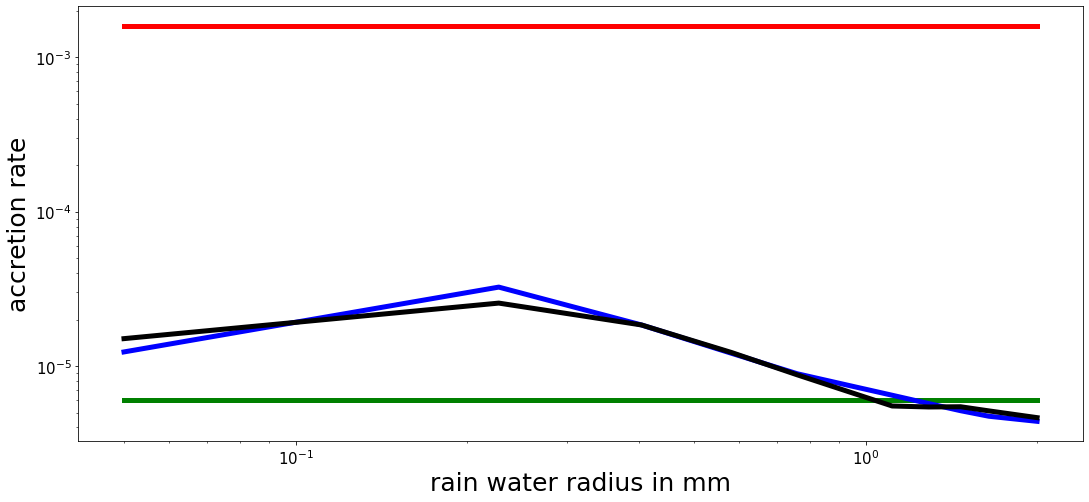

In [83]:

plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, acc3d_model0[iqr,iqc,irc,:,inu], 'g-', linewidth=5)
plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, acc3d_model2[iqr,iqc,irc,:,inu], 'b-', linewidth=5)
plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, acc3d_model3[iqr,iqc,irc,:,inu], 'k-', linewidth=5)
plt.plot(rr3d[iqr,iqc,irc,:,inu]*1e3, accSB[iqr,iqc,irc,:,inu], 'r-', linewidth=5)

plt.xlabel('rain water radius in mm')
plt.ylabel('accretion rate')

plt.yscale('log')
plt.xscale('log')
plt.show()